<a href="https://colab.research.google.com/github/christiaua/ECSE420/blob/master/Lab1/ECSE420-Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check CUDA version > 9.0
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


# Setup environment

In [ ]:
%%script bash

# Remove `/sample_data` & create our folders
rm -rf sample_data
rm -rf input
rm -rf output

mkdir input
mkdir output

## Curl provided files

In [ ]:
%%script bash

cd input/

# save files in `/input`
curl https://raw.githubusercontent.com/christiaua/ECSE420/master/Lab1/files/input_10000.txt > input_10000.txt
curl https://raw.githubusercontent.com/christiaua/ECSE420/master/Lab1/files/input_100000.txt > input_100000.txt
curl https://raw.githubusercontent.com/christiaua/ECSE420/master/Lab1/files/input_1000000.txt > input_1000000.txt
curl https://raw.githubusercontent.com/christiaua/ECSE420/master/Lab1/files/sol_10000.txt > sol_10000.txt
curl https://raw.githubusercontent.com/christiaua/ECSE420/master/Lab1/files/sol_100000.txt > sol_100000.txt
curl https://raw.githubusercontent.com/christiaua/ECSE420/master/Lab1/files/sol_1000000.txt > sol_1000000.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60000  100 60000    0     0  94488      0 --:--:-- --:--:-- --:--:-- 94488
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  585k  100  585k    0     0  1678k      0 --:--:-- --:--:-- --:--:-- 1678k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5859k  100 5859k    0     0  7128k      0 --:--:-- --:--:-- --:--:-- 7119k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20000  100 20000    0     0    97k      0 --:--:-- --:--:-- --:--:--   97k
  % Total    % Received % Xferd  Average Speed   Tim


## Write compareResults.c

In [ ]:
%%writefile compareResults.c

#include <stdio.h>
#include <stdlib.h>


void compareFiles(char *file_name1, char *file_name2) 
{ 
    // get from https://www.tutorialspoint.com/c-program-to-compare-two-files-and-report-mismatches
    FILE* fp1 = fopen(file_name1, "r");
    FILE* fp2 = fopen(file_name2, "r");
 
    // fetching character of two file 
    // in two variable ch1 and ch2 
    char ch1 = getc(fp1); 
    char ch2 = getc(fp2); 
  
    // error keeps track of number of errors 
    // pos keeps track of position of errors 
    // line keeps track of error line 
    int error = 0, pos = 0, line = 1; 
  
    // iterate loop till end of file 
    while (ch1 != EOF && ch2 != EOF) 
    { 
        pos++; 
  
        // if both variable encounters new 
        // line then line variable is incremented 
        // and pos variable is set to 0 
        if (ch1 == '\n' && ch2 == '\n') 
        { 
            line++; 
            pos = 0; 
        } 
  
        // if fetched data is not equal then 
        // error is incremented 
        if (ch1 != ch2) 
        { 
            error++; 
            printf("Line Number : %d \tError"
               " Position : %d \n", line, pos); 
        } 
  
        // fetching character until end of file 
        ch1 = getc(fp1); 
        ch2 = getc(fp2); 
    } 
  
    printf("Total Errors : %d\t\n\n", error); 
} 

int main(int argc, char *argv[]){

    if( argc < 3) {
      printf("Require two files\n");
      exit(1);
    }
    
    compareFiles(argv[1], argv[2]);
}

Overwriting compareResults.c


# Sequential

## Write sequential.c

In [ ]:
%%writefile sequential.c

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>

#define AND '0'
#define OR '1'
#define NAND '2'
#define NOR '3'
#define XOR '4'
#define NXOR '5'

clock_t time_start;
clock_t time_end;

void compute(char* inputPath, char* outputPath);

int main(int argc, char *argv[]){
  if(argc != 4) {
    printf("Usage: ./sequential <input_file_path> <input_file_length> <output_file_path>\n");
    exit(1);
  }

  // Getting inputs
  char *input_path = argv[1];
  char *output_path = argv[3];
  int length = atoi(argv[2]);
  printf("length: %d\n", length);

  int *results;
  results = (int *) malloc (10000 * sizeof(int));

  if(results == NULL){
    printf("Error: Array was null\n");
    return -1;
  }

  // Perform logic gates operation
  compute(input_path, output_path);

  double time_spent = (double)(time_end - time_start) / CLOCKS_PER_SEC;
  printf("Runtime for file of length %d: %.3fms", length, time_spent * 1000);
  
  return 0;
}

void compute(char* inputPath, char* outputPath){
  FILE* fp = fopen(inputPath, "r");
  FILE* fp2 = fopen("output/100000.txt", "w+");

  char * line = NULL;
  size_t len = 0;
  ssize_t read;
  char val1, val2, op;
  int res;

  if (fp == NULL){
    printf("Input file failed to open");
    exit(EXIT_FAILURE);
  }
  if (fp2 == NULL){
    printf("Output file failed to open");
    exit(EXIT_FAILURE);
  }  

  time_start = clock();

  while ((read = getline(&line, &len, fp)) != -1) {
    val1 = line[0];
    val2 = line[2];
    op = line[4];

    switch(op){
        case AND:
          if (val1 == '1' && val2 == '1'){
              res = 1;
          } else {
              res = 0;
          }
          fprintf(fp2,"%d\n",res);
          break;
        case OR:
          if (val1 == '0' && val2 == '0'){
              res = 0;
          } else {
              res = 1;
          }
          fprintf(fp2,"%d\n",res);
          break;
        case NAND:
          if (val1 == '1' && val2 == '1'){
              res = 0;
          } else {
              res = 1;
          }
          fprintf(fp2,"%d\n",res);
          break;
        case NOR:
          if (val1 == '0' && val2 == '0'){
              res = 1;
          } else {
              res = 0;
          }
          fprintf(fp2,"%d\n",res);
          break;
        case XOR:
          if ((val1 == '0' && val2 == '0') || (val1 == '1' && val2 == '1')){
              res = 0;
          } else {
              res = 1;
          }
          fprintf(fp2,"%d\n",res);
          break;
        case NXOR:
          if ((val1 == '0' && val2 == '0') || (val1 == '1' && val2 == '1')){
              res = 1;
          } else {
              res = 0;
          }
          fprintf(fp2,"%d\n",res);
          break;
    }
  }

  time_end = clock();

  fclose(fp);
  fclose(fp2);

}

Writing sequential.c


## Run `./sequential`

In [ ]:
%%script bash
gcc sequential.c  -o sequential

length=10000
input="input/input_${length}.txt"
output="output/${length}.txt"

./sequential $input $length $output

length: 10000
Input file failed to open

# Parallel Explicit


## Write parallelal_explicit.cu

In [ ]:
%%writefile parallelal_explicit.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <time.h>

#define AND '0'
#define OR '1'
#define NAND '2'
#define NOR '3'
#define XOR '4'
#define NXOR '5'

#define INPUT_LINE_SIZE 7
#define OUTPUT_LINE_SIZE 2

__global__ 
void compute(char* input, char* results, int length){
  int i = threadIdx.x + blockIdx.x * blockDim.x;
  char* line = input + INPUT_LINE_SIZE * i;

  char res;
  char val1 = line[0];
  char val2 = line[2];
  char op = line[4];

  switch(op){
    case AND:
      if (val1 == '1' && val2 == '1'){
        res = '1';
      } else {
        res = '0';
      }
      break;
    case OR:
      if (val1 == '0' && val2 == '0'){
        res = '0';
      } else {
        res = '1';
      }
      break;
    case NAND:
      if (val1 == '1' && val2 == '1'){
        res = '0';
      } else {
        res = '1';
      }
      break;
    case NOR:
      if (val1 == '0' && val2 == '0'){
        res = '1';
      } else {
        res = '0';
      }
      break;
    case XOR:
      if ((val1 == '0' && val2 == '0') || (val1 == '1' && val2 == '1')){
        res = '0';
      } else {
        res = '1';
      }
      break;
    case NXOR:
      if ((val1 == '0' && val2 == '0') || (val1 == '1' && val2 == '1')){
        res = '1';
      } else {
        res = '0';
      }
      break;
    default:
      printf("Invalid operator: %c\n", op);
      break;
  }

  char* output = results + OUTPUT_LINE_SIZE * i;
  output[0] = res;
  output[1] = '\0';
}

int main(int argc, char *argv[])
{
  if (argc != 4)
  {
    printf("Usage: ./parallelal_explicit <input_file_path> <input_file_length> <output_file_path>\n");
    exit(1);
  }
 
  char *input_path = argv[1];
  char *output_path = argv[3];
  int length = atoi(argv[2]);
 
  printf("Starting ./parallelal_explicit for file of length %d\n", length);

  FILE *fp_input = fopen(input_path, "r");
  if (fp_input == NULL)
  {
    printf("Input file failed to open");
    exit(EXIT_FAILURE);
  }

  int input_size = length * INPUT_LINE_SIZE * sizeof(char);
  char *input = (char* ) malloc (input_size);
  char line[INPUT_LINE_SIZE];
  int offset = 0;
 
  while (fgets(line, sizeof line, fp_input) != NULL)
  {
    strcpy(input + offset, line);
    offset += INPUT_LINE_SIZE;
  }

  fclose(fp_input);

  int output_size = length * OUTPUT_LINE_SIZE * sizeof(char);
  char *cuda_input;
  char *cuda_output;
  float time;
	cudaEvent_t start, stop;
 	cudaEventCreate(&start);
	cudaEventCreate(&stop);

  // Allocate CUDA memory
  cudaMalloc(&cuda_input, input_size);
  cudaMalloc(&cuda_output, output_size);

  // Copy image from CPU to GPU
  clock_t copy_start = clock();
  cudaMemcpy(cuda_input, input, input_size, cudaMemcpyHostToDevice);
  clock_t copy_end = clock();
  float copy_time = ((copy_end - copy_start) * 1000.0) / CLOCKS_PER_SEC;
  printf("Data migration time: %.3fms\n", copy_time);
 
  int num_thread = 1000;
  int num_block = length/num_thread;
 
  // Timer starts
	cudaEventRecord(start, 0);
 
  compute <<< num_block, num_thread >>> (cuda_input, cuda_output, length);

  // Timer stops
	cudaEventRecord(stop, 0);
	cudaEventSynchronize(stop);
	cudaEventElapsedTime(&time, start, stop);
	printf("Total time: %.3fms\n\n", time);
 
  // Copy image from CPU to GPU
  char *output;
  output = (char*)malloc(output_size * sizeof(char));
	cudaMemcpy(output, cuda_output, output_size, cudaMemcpyDeviceToHost);
 
 
  //Write to output
  FILE* fp_output = fopen(output_path, "w+");
  int lineCount = 0;
  if (fp_output == NULL){
    printf("Output file failed to open");
    exit(EXIT_FAILURE);
  }

  offset = 0;
  while (lineCount < length) {
    if (lineCount == length - 1) {
      fprintf(fp_output, "%s", output + offset);
    }
    else {
      fprintf(fp_output, "%s\n", output + offset);
    }
    offset += OUTPUT_LINE_SIZE;
    lineCount++;
  }

  fclose(fp_output);
  
  // Free memory
  free(input);
  free(output);
  cudaFree(cuda_input);
  cudaFree(cuda_output);
 
  return 0;
}

Overwriting parallelal_explicit.cu


## Run `./parallelal_explicit`

In [ ]:
%%script bash
nvcc parallelal_explicit.cu  -o parallelal_explicit
gcc compareResults.c  -o compareResults

length=10000
input="input/input_${length}.txt"
output="output/${length}.txt"
expected="input/sol_${length}.txt"

./parallelal_explicit $input $length $output
./compareResults $expected $output

Starting ./parallelal_explicit for file of length 10000
Data migration time: 0.034ms
Total time: 0.048ms

Total Errors : 0	



# Parallel Unified


## Write parallelal_unified.cu

https://developer.nvidia.com/blog/unified-memory-cuda-beginners/

In [ ]:
%%writefile parallelal_unified.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <cuda_runtime.h>

#define AND '0'
#define OR '1'
#define NAND '2'
#define NOR '3'
#define XOR '4'
#define NXOR '5'
#define INPUT_LINE_SIZE 7
#define OUTPUT_LINE_SIZE 3

__global__ 
void compute(char* input, char* results, int length){
  int i = threadIdx.x + blockIdx.x * blockDim.x;
  char* line = input + INPUT_LINE_SIZE * i;

  char res;
  char val1 = line[0];
  char val2 = line[2];
  char op = line[4];
  
    switch(op){
    case AND:
      if (val1 == '1' && val2 == '1'){
        res = '1';
      } else {
        res = '0';
      }
      break;
    case OR:
      if (val1 == '0' && val2 == '0'){
        res = '0';
      } else {
        res = '1';
      }
      break;
    case NAND:
      if (val1 == '1' && val2 == '1'){
        res = '0';
      } else {
        res = '1';
      }
      break;
    case NOR:
      if (val1 == '0' && val2 == '0'){
        res = '1';
      } else {
        res = '0';
      }
      break;
    case XOR:
      if ((val1 == '0' && val2 == '0') || (val1 == '1' && val2 == '1')){
        res = '0';
      } else {
        res = '1';
      }
      break;
    case NXOR:
      if ((val1 == '0' && val2 == '0') || (val1 == '1' && val2 == '1')){
        res = '1';
      } else {
        res = '0';
      }
      break;
    default:
      printf("Invalid operator: %c\n", op);
      break;
  }

  char* output = results + OUTPUT_LINE_SIZE * i;
  output[0] = res;
  output[1] = '\0'; 

}

int main(int argc, char *argv[])
{
  if (argc != 4)
  {
    printf("Usage: ./parallelal_unified <input_file_path> <input_file_length> <output_file_path>\n");
    exit(1);
  }
 
  char *input_path = argv[1];
  char *output_path = argv[3];
  int length = atoi(argv[2]);
 
  printf("Starting ./parallelal_unified for file of length %d\n", length);

  FILE *fp_input = fopen(input_path, "r");
  if (fp_input == NULL)
  {
    printf("Input file failed to open");
    exit(EXIT_FAILURE);
  }

  // Get content of input file
  int input_size = length * INPUT_LINE_SIZE * sizeof(char);
  char *input = (char* ) malloc (input_size);
  char line[INPUT_LINE_SIZE];
  int offset = 0;
 
  while (fgets(line, sizeof line, fp_input) != NULL)
  {
    strcpy(input + offset, line);
    offset += INPUT_LINE_SIZE;
  }

  fclose(fp_input);

  int output_size = length * OUTPUT_LINE_SIZE * sizeof(char);
  char *cuda_input;
  char *cuda_output;

  cudaMallocManaged(&cuda_input, input_size);
  cudaMallocManaged(&cuda_output, output_size);

  // copy input file content to be used for kernel operation
  for (int i = 0; i < input_size; i++) {
    cuda_input[i] = input[i]; 
  }

  int num_thread = 1000;
  int num_block = length/num_thread;
 
  // # Timer starts
	float time;
	cudaEvent_t start, stop;
	cudaEventCreate(&start);
	cudaEventCreate(&stop);
	cudaEventRecord(start, 0);
 
  compute <<< num_block, num_thread >>> (cuda_input, cuda_output, length);

  cudaDeviceSynchronize();
 
 	// # Timer stops
	cudaEventRecord(stop, 0);
	cudaEventSynchronize(stop);
	cudaEventElapsedTime(&time, start, stop);
	printf("Total time: %.3fms\n\n", time);

  // Write to output
  FILE* fp_output = fopen(output_path, "w+");
 
  int lineCount = 0;
  if (fp_output == NULL){
    printf("Output file failed to open");
    exit(EXIT_FAILURE);
  }

  offset = 0;
  while (lineCount < length) {
    if (lineCount == length - 1) {
      fprintf(fp_output, "%s", cuda_output + offset);
    }
    else {
      fprintf(fp_output, "%s\n", cuda_output + offset);
    }
    offset += OUTPUT_LINE_SIZE;
    lineCount++;
  }

  fclose(fp_output);
  
  // Free memory
  free(input);
  cudaFree(cuda_input);
  cudaFree(cuda_output);
 
  return 0;
}

Overwriting parallelal_unified.cu


## Run ./parallelal_unified

In [ ]:
%%script bash
nvcc parallelal_unified.cu  -o parallelal_unified

length=1000000
input="input/input_${length}.txt"
output="output/${length}.txt"

./parallelal_unified $input $length $output

length: 1000000
Time for file of length: 1000000: 22.203ms, 

# Benchmarking


Text(0, 0.5, 'Execution time (ms)')

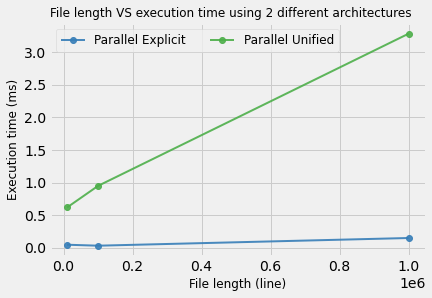

In [ ]:
import matplotlib.pyplot as plt 
import matplotlib as mpl
import pandas as pd

plt.style.use("fivethirtyeight")
d = {'x': [10000, 100000, 1000000], 
    #  'Sequential': [1.388, 13.333, 135.928], 
     'Parallel Explicit': [0.047, 0.032, 0.150], 
     'Parallel Unified': [0.618, 0.950, 3.285]}
df = pd.DataFrame(data=d)

palette = plt.get_cmap('Set1')
num=0
for column in df.drop('x', axis=1):
  num = num + 1
  plt.plot(df['x'], df[column], marker='o', color=palette(num), linewidth=2, alpha=0.9, label=column)
 
plt.legend(loc=2, ncol=2, fontsize=12)
plt.title("File length VS execution time using 2 different architectures", loc='left', fontsize=12, fontweight=0, color='black')
plt.xlabel("File length (line)", fontsize=12)
plt.ylabel("Execution time (ms)", fontsize=12)


Text(0, 0.5, 'Data migration time (ms)')

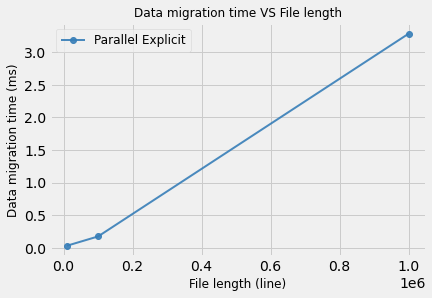

In [ ]:
import matplotlib.pyplot as plt 
import matplotlib as mpl
import pandas as pd

plt.style.use("fivethirtyeight")
d = {'x': [10000, 100000, 1000000], 
     'Parallel Explicit': [0.035, 0.177, 3.285]} 
df = pd.DataFrame(data=d)

palette = plt.get_cmap('Set1')
num=0
for column in df.drop('x', axis=1):
  num = num + 1
  plt.plot(df['x'], df[column], marker='o', color=palette(num), linewidth=2, alpha=0.9, label=column)
 
plt.legend(loc=2, ncol=2, fontsize=12)
plt.title("Data migration time VS File length", loc='center', fontsize=12, fontweight=0, color='black')
plt.xlabel("File length (line)", fontsize=12)
plt.ylabel("Data migration time (ms)", fontsize=12)
